In [1]:
import sys
import io
sys.path.append("..")
import pkgutil

import seaborn as sns
import numpy as np

from cobra.io import read_sbml_model
from cobra.core import model
from cobra.flux_analysis import phenotype_phase_plane, pfba
from typing import List, Tuple, Iterable, Any
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.lines import Line2D

import escher

from rubisco_carboxysome import (
    DEFAULT_MAX_N_KO, WILDTYPE_MODEL, CARBON_SOURCES_LIST, SINGLE_KOS,
    TARGET_REACTION
)

plt.style.use('seaborn-whitegrid')
plt.ion();

In [2]:
model_binary = pkgutil.get_data("rubisco_carboxysome", "core_model_with_rpp_and_fdh.xml")
wt_model = read_sbml_model(model_binary.decode("UTF-8"))

In [16]:
def create_ko_model(
    wt_model: model,
    knockouts: Iterable[str],
    carbon_sources: Iterable[str],
) -> model:
    ko_model = wt_model.copy()
    for ko in knockouts:
        for k in ko.split('|'):
            ko_model.reactions.get_by_id(k).knock_out()
    for cs in carbon_sources:
        ko_model.reactions.get_by_id("EX_" + cs + "_e").lower_bound = -1000.0
    return ko_model

def production_envelope(
        wt_model: model,
        knockouts: Iterable[str],
        carbon_sources: Iterable[str],
        target_reaction: str,
        points: int = 20
) -> pd.DataFrame:
    """Calculates the data of the production envelope for a KO.

    :param wt_model: the Wild-Type model without any knockouts
    :param knockouts: the list of KOs
    :param carbon_sources: the list of carbon sources
    :param target_reaction: the reaction to place on the x-axis of the PPP
    :return: A DataFrame with the biomass yield ranges for each x-value
    """
    ko_model = wt_model.copy()
    for ko in knockouts:
        for k in ko.split('|'):
            ko_model.reactions.get_by_id(k).knock_out()
    for cs in carbon_sources:
        ko_model.reactions.get_by_id("EX_" + cs + "_e").lower_bound = -100.0
    return phenotype_phase_plane.production_envelope(
        ko_model, target_reaction, points=points)


def plot_envelope(
        ko_model: model,
        target_reaction: str,
        ax: plt.Axes,
        label: str = None,
        color: Any = 'b'):
    prod_env_df = production_envelope(
        wt_model=ko_model.copy(),
        knockouts=[],
        carbon_sources=[],
        target_reaction=target_reaction,
        points=200)

    label = label or ','.join(carbon_sources)
    ax.plot(prod_env_df.flux_minimum,
            prod_env_df[target_reaction],
            c=color, ls='-', lw=1, label=label)
    ax.plot(prod_env_df.flux_maximum,
            prod_env_df[target_reaction],
            c=color, ls='-', lw=1, label='')

    ax.fill_betweenx(
        prod_env_df[target_reaction],
        prod_env_df.flux_minimum,
        prod_env_df.flux_maximum,
        linewidth=0,
        alpha=0.2,
        facecolor=color,
        label='')

def calculate_slope(
    ko_model: model,
    target_reaction: str
) -> float:
    model = ko_model.copy()
    target_rxn = model.reactions.get_by_id(target_reaction)
    target_rxn.bounds = (0.0, 0.0)
    sol = model.optimize()
    if sol.status == "optimal" and sol.objective_value > 1e-5:
        return 0.0 # this strain is not rubisco dependent at all
    
    upper_bound = 0.01
    target_rxn.bounds = (0.0, upper_bound)
    sol = model.optimize()
    if sol.status != "optimal" or sol.objective_value <= 1e-5:
        return np.inf # this strain cannot grow even with rubisco
    else:
        return upper_bound / sol.objective_value

def display_flux_solution(
    ko_model: model,
    growth_rate: float
) -> None:
    m = ko_model.copy()
    m.reactions.BIOMASS_Ecoli_core_w_GAM.bounds = (growth_rate - 1e-6, growth_rate + 1e-6)
    sol = ko_model.optimize()
    solution = pfba(ko_model)
    return escher.Builder(map_name="e_coli_core.Core metabolism", reaction_data=solution.fluxes)

In [4]:
strain_df = pd.read_csv(
    io.StringIO(pkgutil.get_data("rubisco_carboxysome", "rubisco_strains_yield.csv").decode("UTF-8"))
)

In [5]:
models = []
for idx, row in strain_df.iterrows():
    if pd.isnull(row.carbon_source):
        carbon_sources = []
    else:
        carbon_sources = [row.carbon_source]
    if row.added_formate:
        carbon_sources += ["for"]

    models.append(
        create_ko_model(
            wt_model,
            knockouts=([] if pd.isnull(row["knockouts"]) else [row["knockouts"]]),
            carbon_sources=carbon_sources,
        )
    )
strain_df["model"] = models

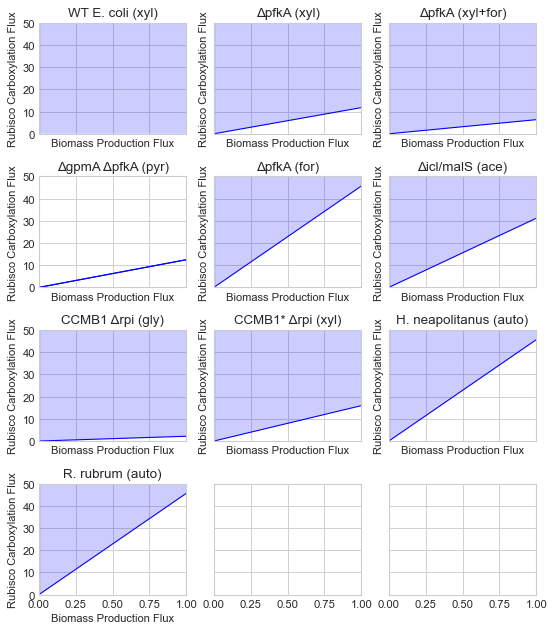

In [6]:
# gapA KO was previously published by Mueller-Cajar '07 and others.
# Plot shows that this strain has slope 0 on sample carbon sources.
n_rows = int(strain_df.shape[0]/3 + 0.7)
fig, axs = plt.subplots(n_rows, 3, figsize=(7, n_rows*2), sharex=True, sharey=True, dpi=80)

for row, ax in zip(strain_df.itertuples(), axs.flat):
    plot_envelope(
        row.model,
        target_reaction="RBC",
        ax=ax
    )

    ax.set_title(row.description)
    ax.set_xlabel('Biomass Production Flux')
    ax.set_ylabel('Rubisco Carboxylation Flux')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 50)

fig.tight_layout()
display(fig)
plt.close(fig)

In [7]:
calculated_slopes = []
for row, ax in zip(strain_df.itertuples(), axs.flat):
    slope = calculate_slope(row.model, target_reaction="RBC")
    calculated_slopes.append(slope)
strain_df["slope"] = calculated_slopes
strain_df["rubisco_coupling_percent"] = 100.0 * strain_df.slope / strain_df.slope.max()
strain_df

description        knockouts carbon_source  added_formate  \
0        WT E. coli (xyl)              NaN       xu5p__D          False   
1             ΔpfkA (xyl)      PFK|G6PDH2r       xu5p__D          False   
2         ΔpfkA (xyl+for)      PFK|G6PDH2r       xu5p__D           True   
3       ΔgpmA ΔpfkA (pyr)  PGM|PFK|G6PDH2r           pyr          False   
4             ΔpfkA (for)      PFK|G6PDH2r           NaN           True   
5         Δicl/malS (ace)              ICL            ac          False   
6        CCMB1 Δrpi (gly)      RPI|EDD|EDA          dhap          False   
7       CCMB1* Δrpi (xyl)      RPI|EDD|EDA       xu5p__D          False   
8  H. neapolitanus (auto)              NaN           NaN           True   
9        R. rubrum (auto)              NaN           NaN           True   

   elevated_co2  autotrophic  growth_rate  uptake_rate        model  \
0         False        False         0.50         47.5  e_coli_core   
1          True        False         0.15         14.5  e_coli_core   
2          True        False         0.17         14.5  e_coli_core   
3          True        False         0.10          NaN  e_coli_core   
4          True         True         0.04          2.1  e_coli_core   
5          True        False         0.07          NaN  e_coli_core   
6         False        False         0.20         28.5  e_coli_core   
7         False        False         0.10          9.5  e_coli_core   
8         False         True         0.23          NaN  e_coli_core   
9          True         True         0.14          NaN  e_coli_core   

       slope  rubisco_coupling_percent  
0   0.000000                  0.000000  
1  11.776157                 25.827455  
2   6.355875                 13.939698  
3  12.462900                 27.333618  
4  45.595500                100.000000  
5  31.115400                 68.242261  
6   2.156400                  4.729414  
7  15.923030                 34.922371  
8  45.595500                100.000000  
9  45.595500                100.000000

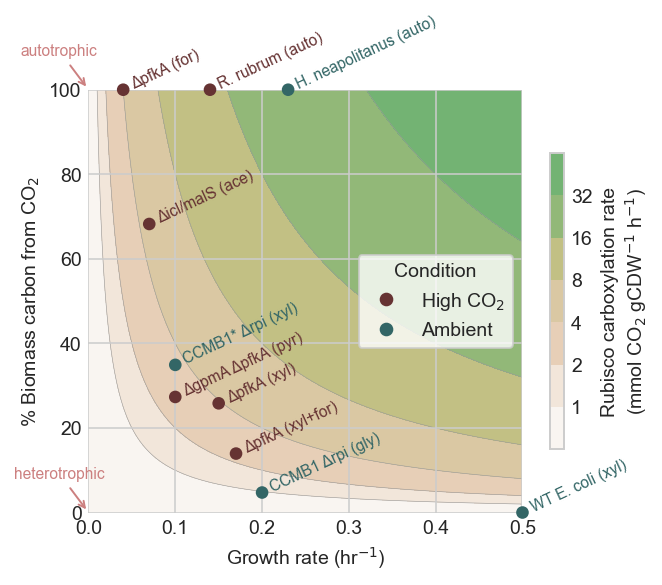

In [8]:
trophic_color = (0.8, 0.5, 0.5)
high_co2_color = (0.4, 0.2, 0.2)
ambient_color = (0.2, 0.4, 0.4)

strain_df["color"] = strain_df.elevated_co2.apply(lambda x: high_co2_color if x else ambient_color)

# Plot Growth rate vs Slope
fig, ax = plt.subplots(figsize=(5, 4), dpi=140)
ax.scatter(
    strain_df.growth_rate, strain_df.rubisco_coupling_percent, s=30,
    color=strain_df.color.values, clip_on=False
)

# Axis labels
ax.set_xlabel("Growth rate (hr$^{-1}$)")
ax.set_ylabel("% Biomass carbon from CO$_2$")

# Label data points
for row in strain_df.itertuples():
    ax.annotate(
        text=row.description,
        xy=(row.growth_rate, row.rubisco_coupling_percent),
        rotation=25, fontsize=8, xytext=(3, -1), color=row.color,
        ha="left", va="bottom", textcoords='offset points'
    )

allGR = np.linspace(0, 0.5, 500)
allRC = np.linspace(0, 100, 500)
X, Y = np.meshgrid(allGR, allRC)
Z = X*Y

cmap = LinearSegmentedColormap.from_list(
    "light_greens",
    [
        (0.0, (0.99, 0.99, 0.99)),
        (0.1, (0.9,  0.8,  0.7)),
        (0.4, (0.75, 0.75,  0.5)),
        (1.0, (0.45, 0.7,  0.45))
    ]
)
levels = [1, 2, 4, 8, 16, 32, 1e4]
CS = plt.contourf(X, Y, Z, cmap=cmap, vmin=0, vmax=32, levels=[0] + levels, zorder=-1)
plt.contour(X, Y, Z, colors=[(0.6, 0.6, 0.6)], linewidths=[0.3], vmin=0, vmax=16, levels=levels, zorder=0)
plt.colorbar(CS, shrink=0.7, label="Rubisco carboxylation rate\n(mmol CO$_2$ gCDW$^{-1}$ h$^{-1}$)", ticks=levels[0:-1])

ax.annotate(
    text="autotrophic", xy=(0.0, 100), color=trophic_color, ha="center", va="center",
    xytext=(-15, 20), textcoords='offset points', fontsize=8,
    arrowprops={"arrowstyle": "->", "color": trophic_color}
)
ax.annotate(
    text="heterotrophic", xy=(0.0, 0), color=trophic_color, ha="center", va="center",
    xytext=(-15, 20), textcoords='offset points', fontsize=8,
    arrowprops={"arrowstyle": "->", "color": trophic_color}
)

legend_elements = [
    Line2D([0], [0], color=high_co2_color, marker="o", lw=0, label='High CO$_2$'),
    Line2D([0], [0], color=ambient_color, marker="o", lw=0, label='Ambient'),
]
ax.legend(handles=legend_elements, loc="center right", frameon=True, title="Condition");

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xlim([0, 0.5])
ax.set_ylim([0, 100])

fig.savefig("slope_vs_growth_rate.png")

In [9]:
wt_model.reactions.BIOMASS_Ecoli_core_w_GAM

<Reaction BIOMASS_Ecoli_core_w_GAM at 0x7f19c23364f0>

## Predict the uptake rate based on the FBA model and measured growth rate

In [18]:
def calculate_uptake_rate(ko_model: model, carbon_source: str, growth_rate: float) -> float:
    m = ko_model.copy()
    m.reactions.BIOMASS_Ecoli_core_w_GAM.bounds = (growth_rate - 1e-6, growth_rate + 1e-6)
    sol = m.optimize()
    if sol.status == "infeasible":
        return np.nan
    solution = pfba(m, fraction_of_optimum=0.9)
    carbons_per_mole = wt_model.metabolites.get_by_id(carbon_source + "_c").elements["C"]
    return -solution.fluxes["EX_" + carbon_source + "_e"] * carbons_per_mole
    
uptake_rates = []
for row in strain_df.itertuples():
    if pd.isnull(row.carbon_source):
        uptake_rates.append(np.nan)
    else:
        uptake_rates.append(calculate_uptake_rate(row.model, row.carbon_source, row.growth_rate))
strain_df["calculated_uptake_rate"] = uptake_rates


In [23]:
strain_df[
    ["description", "elevated_co2", "autotrophic", "growth_rate", "uptake_rate", "rubisco_coupling_percent", "calculated_uptake_rate"]
].round(2).to_csv("results.csv")

## Show the fluxes solution for the ΔrpiAB Δedd mutant with limiting Rubisco flux

In [17]:
row = strain_df.iloc[1, :]
print(row)
display_flux_solution(row.model, row.growth_rate)

description                     ΔpfkA (xyl)
knockouts                       PFK|G6PDH2r
carbon_source                       xu5p__D
added_formate                         False
elevated_co2                           True
autotrophic                           False
growth_rate                            0.15
uptake_rate                            14.5
model                           e_coli_core
slope                             11.776157
rubisco_coupling_percent          25.827455
color                       (0.4, 0.2, 0.2)
calculated_uptake_rate             9.951089
Name: 1, dtype: object


Builder(reaction_data={'ACALD': -82.80638980022951, 'ACALDt': 0.0, 'ACKr': -379.99713367264815, 'ACONTa': 229.…